In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from PIL import Image

### Парсинг данных

In [5]:
def parse_lidar(fname):
    coordinates = []
    lidar = []

    with open(fname, 'r') as file:
        for row in file.readlines():
            coordinates.append([float(i) for i in row.split('; ')[0].split(', ')])
            lidar.append([float(i) for i in row.split('; ')[1].split(', ')])

    coordinates = np.array(coordinates)
    lidar = np.array(lidar)

    return (coordinates, lidar)

### Перевод одного прохода лидара в декартовы координаты

In [6]:
def calculate_session(pos, lidar_data):
    lidar_data = lidar_data.copy()
    lidar_data[lidar_data == 5.6] = np.nan
    lidar_data[lidar_data < 0.3] = np.nan
    
    angles = np.linspace(pos[2] + 2*np.pi/3, pos[2] - 2*np.pi/3, len(lidar_data))

    x = np.array(lidar_data * np.cos(angles) + pos[0])
    x = x[~np.isnan(x)]
    y = np.array(lidar_data * np.sin(angles) + pos[1])
    y = y[~np.isnan(y)]
    
    return [x, y] 

### Строим график

In [107]:
import numpy as np

class KalmanFilter:
    def __init__(self, initial_state_covariance, process_noise_covariance, measurement_noise_covariance):
        self.state_estimate = np.zeros((3, 1))  # Initial state estimate [x, y, theta]
        self.state_covariance = initial_state_covariance  # Initial state covariance matrix
        self.process_noise_covariance = process_noise_covariance  # Process noise covariance matrix
        self.measurement_noise_covariance = measurement_noise_covariance  # Measurement noise covariance matrix
        self.identity_matrix = np.eye(3)  # Identity matrix

    def predict(self, delta_t, v, omega):
        # State prediction
        theta = self.state_estimate[2, 0]
        self.state_estimate[0, 0] += delta_t * (v * np.cos(theta))
        self.state_estimate[1, 0] += delta_t * (v * np.sin(theta))
        self.state_estimate[2, 0] += delta_t * omega

        # Jacobian of the motion model
        G = np.array([[1, 0, -delta_t * v * np.sin(theta)],
                      [0, 1, delta_t * v * np.cos(theta)],
                      [0, 0, 1]])

        # Process noise covariance update
        self.state_covariance = G @ self.state_covariance @ G.T + self.process_noise_covariance

    def update(self, measurement):
        # Measurement prediction
        H = np.eye(3)  # Jacobian of the measurement model, identity matrix
        predicted_measurement = H @ self.state_estimate
        residual = measurement - predicted_measurement

        # Measurement residual covariance
        S = H @ self.state_covariance @ H.T + self.measurement_noise_covariance

        # Kalman gain
        K = self.state_covariance @ H.T @ np.linalg.inv(S)

        # Update state estimate and covariance
        self.state_estimate += K @ residual
        self.state_covariance = (self.identity_matrix - K @ H) @ self.state_covariance

# Пример использования фильтра Калмана для оценки позиции робота
initial_state_covariance = np.eye(3) * 0.1  # Initial state covariance matrix
process_noise_covariance = np.eye(3) * 0.01  # Process noise covariance matrix
measurement_noise_covariance = np.eye(3) * 0.1  # Measurement noise covariance matrix

# Создание объекта фильтра Калмана
kf = KalmanFilter(initial_state_covariance, process_noise_covariance, measurement_noise_covariance)

# Пример данных одометрии (время, скорость и угловая скорость)

coordinates, lidar = parse_lidar(f'raw_data/examp{j}.txt')
odometry_data = np.copy(coordinates)


# Создание пустого списка для хранения отфильтрованных данных
filtered_data = []

# Применение фильтра Калмана к каждому измерению
for data in odometry_data:
    x, y, theta = data
    measurement = np.array([[x], [y], [theta]])  # Преобразование данных одометрии в формат измерения
    kf.update(measurement)  # Обновление состояния фильтра по текущему измерению
    filtered_data.append(kf.state_estimate.flatten())  # Добавление отфильтрованного состояния в список

# Преобразование списка отфильтрованных данных в массив для удобства использования
filtered_data = np.array(filtered_data)

# Вывод отфильтрованных данных
print("Filtered data:")
print(filtered_data)






Filtered data:
[[ 2.15501    -1.6707515  -1.4426545 ]
 [ 2.830029   -2.23916433 -1.923035  ]
 [ 3.16196225 -2.524877   -2.1632455 ]
 [ 3.3515768  -2.6987332  -2.3071198 ]
 [ 3.4550285  -2.82066    -2.402814  ]
 [ 3.518022   -2.91064586 -2.47128729]
 [ 3.54676987 -2.98310925 -2.52353325]
 [ 3.56121689 -3.04155833 -2.56457544]
 [ 3.5656317  -3.090179   -2.5975855 ]
 [ 3.55682455 -3.13299618 -2.62852164]
 [ 3.54374358 -3.1697095  -2.65913758]
 [ 3.52721931 -3.20121631 -2.69050615]
 [ 3.50265943 -3.22796179 -2.27942307]
 [ 3.47654727 -3.250465   -1.92826413]
 [ 3.44465169 -3.26803231 -1.62835213]
 [ 3.41220971 -3.28232676 -1.36431929]
 [ 3.37960733 -3.29383878 -1.13193061]
 [ 3.34345368 -3.30125726 -0.93066895]
 [ 3.30768825 -3.30620615 -0.75325665]
 [ 3.27244881 -3.30875562 -0.59634738]
 [ 3.23526523 -3.30683945 -0.46067909]
 [ 3.19907083 -3.30279057 -0.33997583]
 [ 3.16215317 -3.29434113 -0.23366838]
 [ 3.12656224 -3.28425744 -0.1380758 ]
 [ 3.09220892 -3.27258335 -0.05222319]
 [ 3.05790

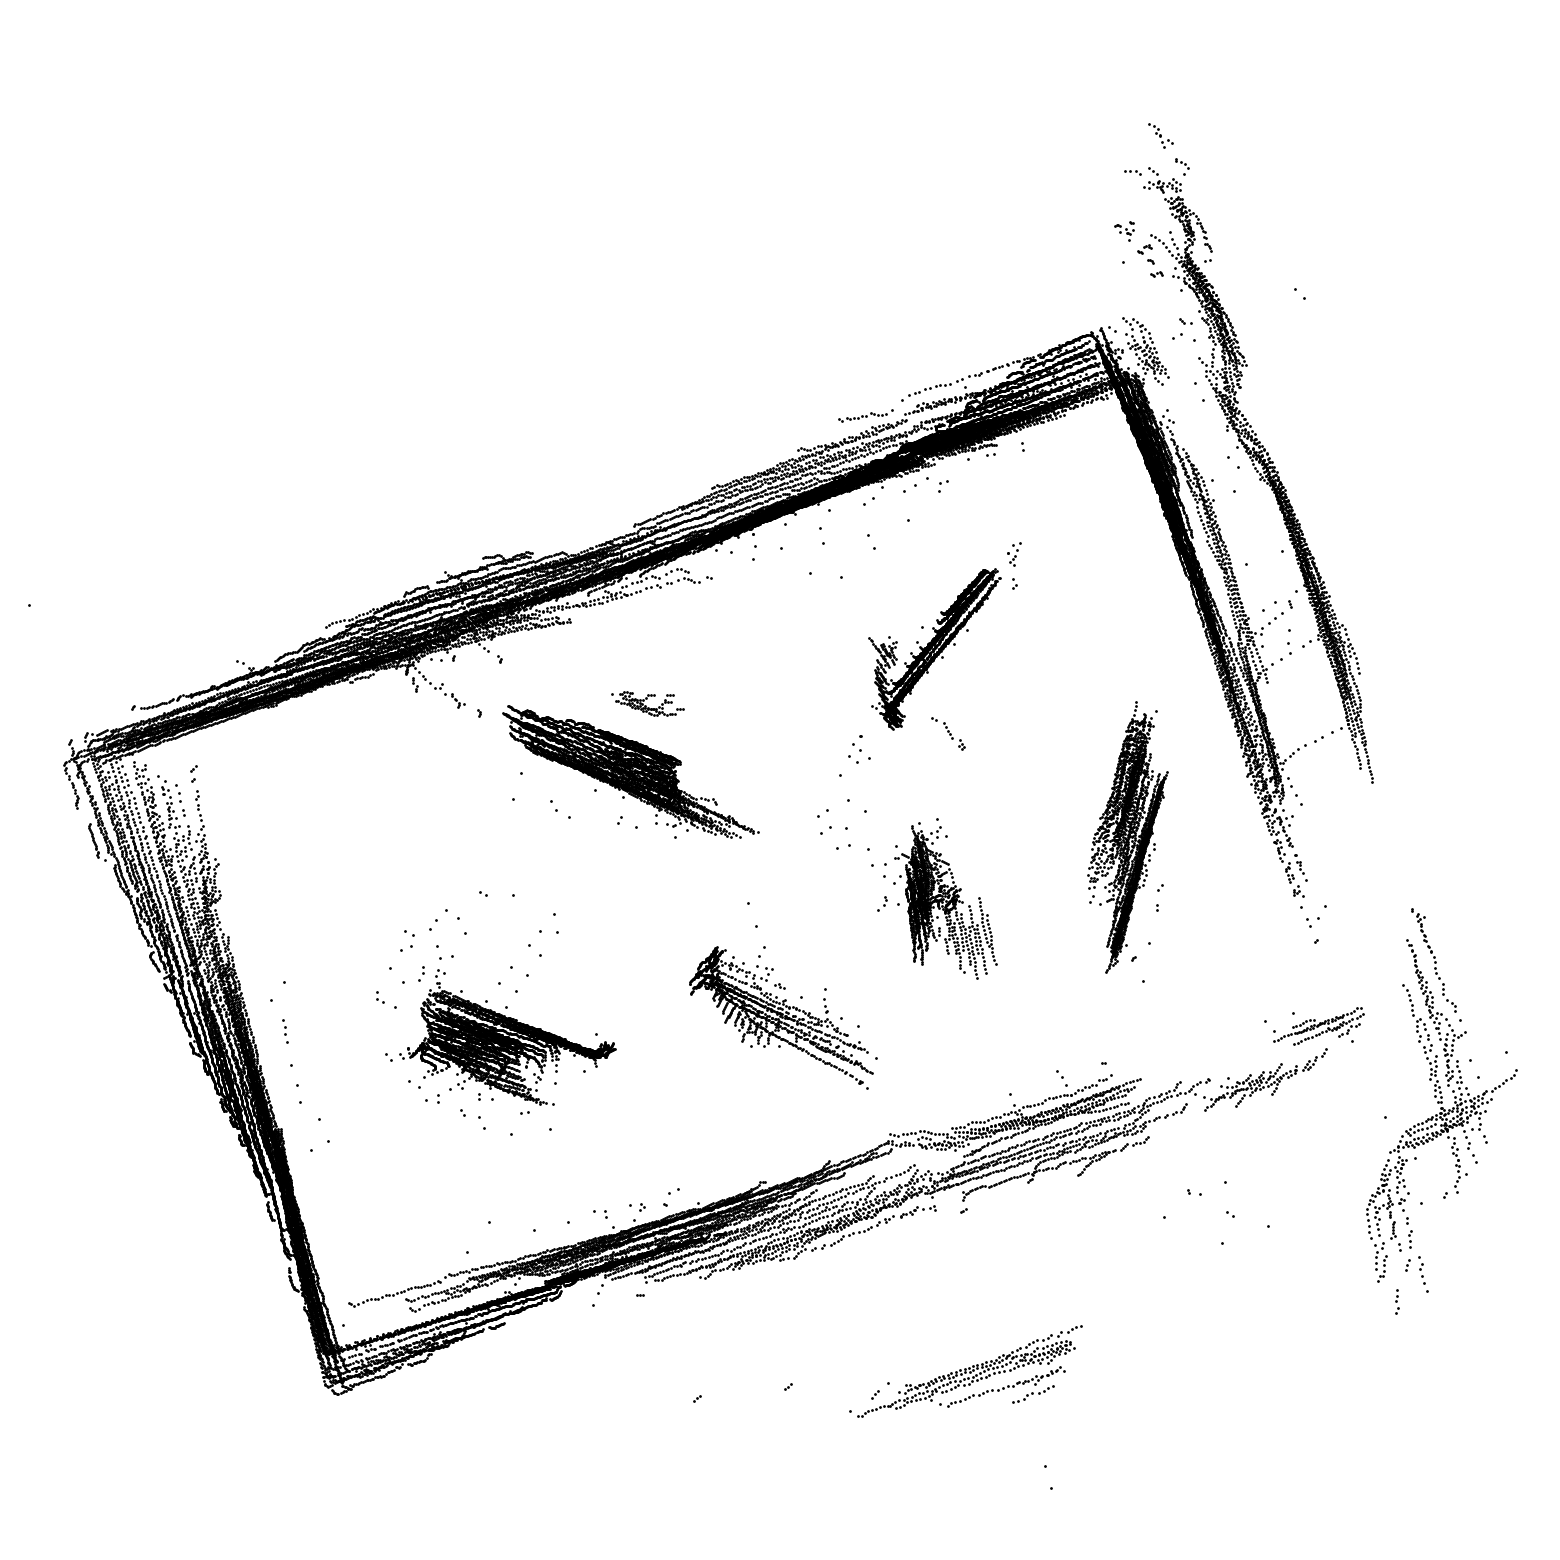

In [109]:
j = 7

points_all = [np.array([]), np.array([])]
for i in range(coordinates.shape[0]):
    points_session = calculate_session(coordinates[i], lidar[i])
    points_all[0] = np.concatenate((points_all[0], points_session[0]))
    points_all[1] = np.concatenate((points_all[1], points_session[1]))

fig, ax = plt.subplots()

fig.set_figheight(20)
fig.set_figwidth(20)
ax.axis('off')

#ax.plot(points_all[0], points_all[1], ',', 'k')
ax.scatter(points_all[0], points_all[1], 1, 'k')

ax.set_xlim((0, 10))
ax.set_ylim((-6, 4))
ax.set_aspect (1)

fig.savefig(f'tmp/ex_t{j}.jpg', dpi=100)

In [61]:
cv2.imread('tmp/ex_t7.png', cv2.IMREAD_GRAYSCALE)

array([  0, 255], dtype=uint8)

### Видос

In [3]:
coordinates, lidar = parse_lidar(f'lidar_data/examp{7}.txt')
size = (2000, 2000)
out = cv2.VideoWriter('vids_lidar/vid_7_test.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, size)

fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)
ax.set_xlim((0, 10))
ax.set_ylim((-6, 4))
ax.set_aspect (1)
for i in range(coordinates.shape[0]):
#for i in range(10):

    points_session = calculate_session(coordinates[i], lidar[i])

    ax.scatter(points_session[0], points_session[1], 1, 'k')
    ax.scatter(coordinates[i, 0], coordinates[i, 1], 5, 'r')
    
    fig.savefig(f'vids_lidar/temp.jpg', dpi=100, transparent=True)
    frame = cv2.imread(f'vids_lidar/temp.jpg')
    frame = cv2.resize(frame, size)

    out.write(frame)
out.release()



NameError: name 'parse_lidar' is not defined

### Попытки обработать полученную картину

Идея такова:
 - Построить портрет для каждой сессии
 - Накинуть блюр, в попытке убрать какой нибудь шум
 - Выделить предполагаемые препятствия с помощью кенни

In [ ]:
for i in range(coordinates.shape[0]):
    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.axis('off')
    ax.set_xlim((0, 10))
    ax.set_ylim((-6, 4))
    ax.set_aspect (1)
    points_session = calculate_session(coordinates[i], lidar[i])
    ax.scatter(points_session[0], points_session[1], 1, 'k')
    fig.savefig(f'frames_lidar7/frame{i}.jpg', dpi=100, transparent=True)
    fig.clear()
    ax.clear()

    frame = cv2.imread(f'frames_lidar7/frame{i}.jpg')
    frame = cv2.Canny(cv2.blur(frame, (9, 9)), 100, 200)

    cv2.imwrite(f'frames_lidar7/frame{i}.jpg', frame)

 - А потом сложить все эти портреты, чтобы получить один общий

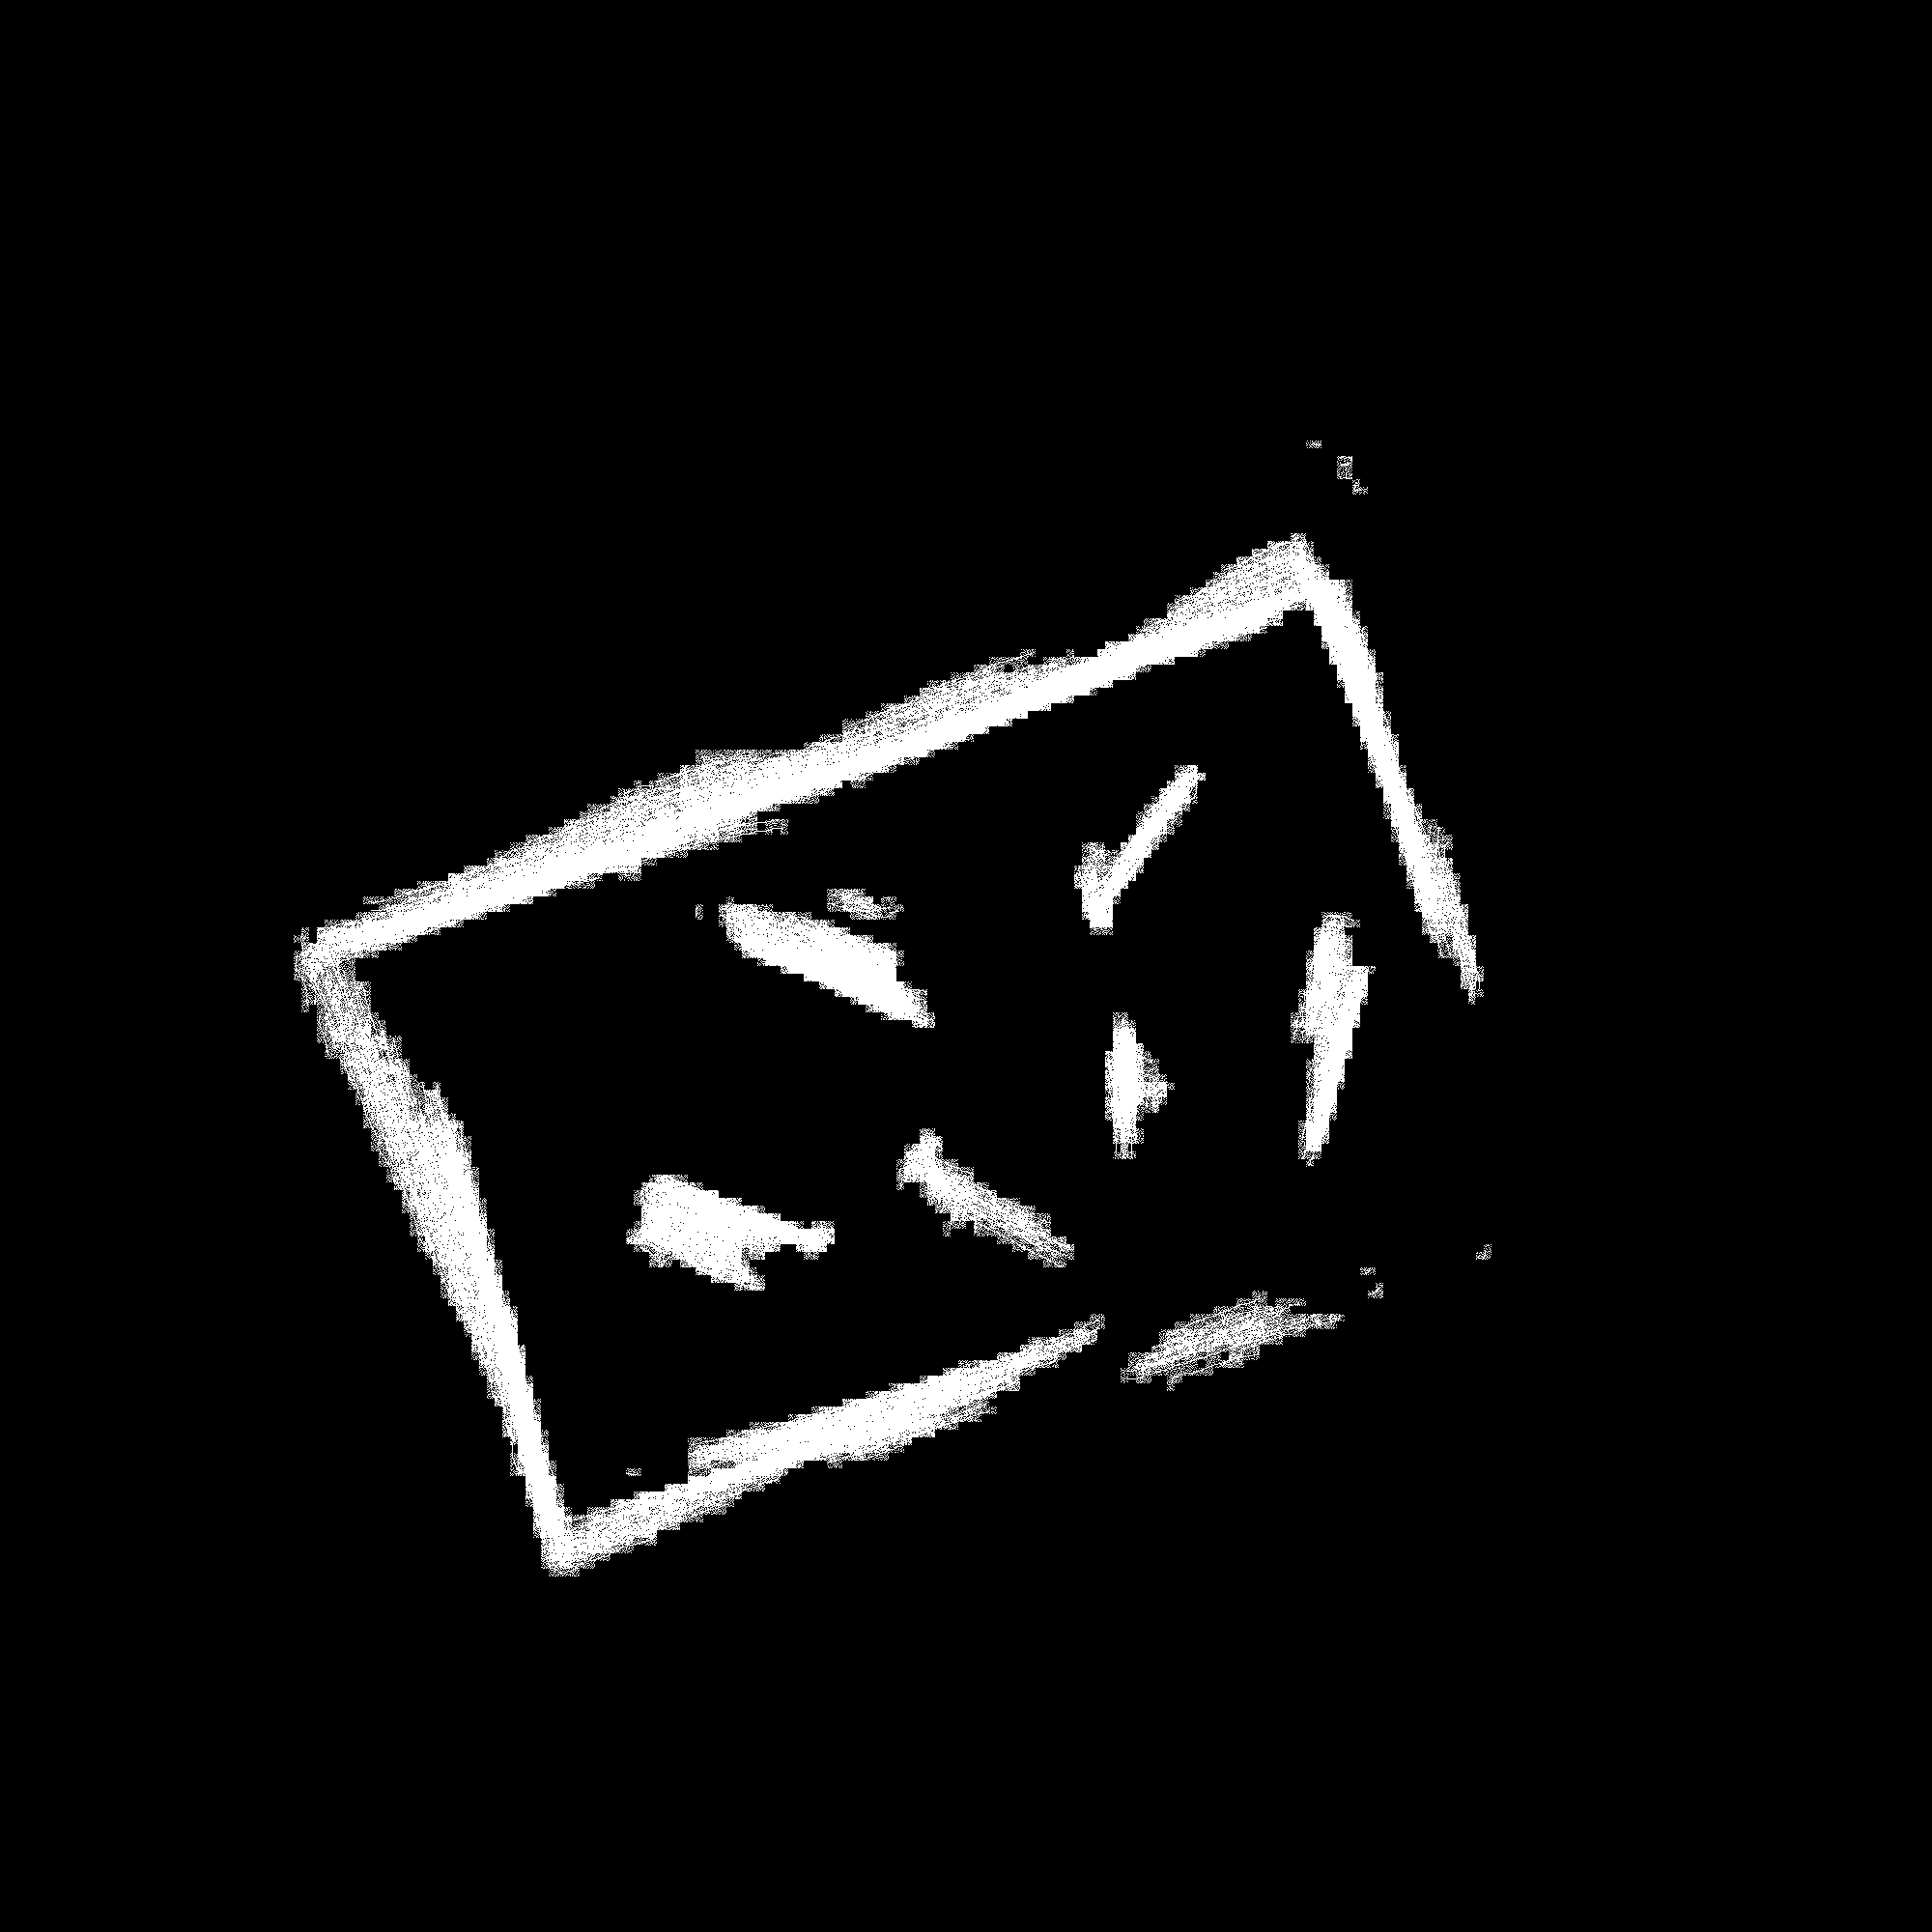

In [21]:
res = cv2.imread('frames_lidar7/frame0.jpg', cv2.IMREAD_GRAYSCALE).astype(bool)

for i in range(100):
    # fig, ax = plt.subplots()
    # fig.set_figheight(20)
    # fig.set_figwidth(20)
    # ax.axis('off')
    # ax.set_xlim((0, 10))
    # ax.set_ylim((-6, 4))
    # ax.set_aspect (1)
    # points_session = calculate_session(coordinates[i], lidar[i])
    # ax.scatter(points_session[0], points_session[1], 1, 'k')
    # fig.savefig(f'frames_lidar7/frame{i}.jpg', dpi=100, transparent=True)
    # fig.clear()
    # ax.clear()

    frame = cv2.imread(f'frames_lidar7/frame{i}.jpg')
    frame = cv2.Canny(cv2.blur(frame, (9, 9)), 100, 200)
    
    im = cv2.imread(f'frames_lidar7/frame{i}.jpg', cv2.IMREAD_GRAYSCALE).astype(bool)
    res = np.logical_or(im, res)

res = res.astype(np.uint8) * 255

Image.fromarray(res)

C:\Users\Mi\AppData\Local\Temp\ipykernel_14800\4072278509.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


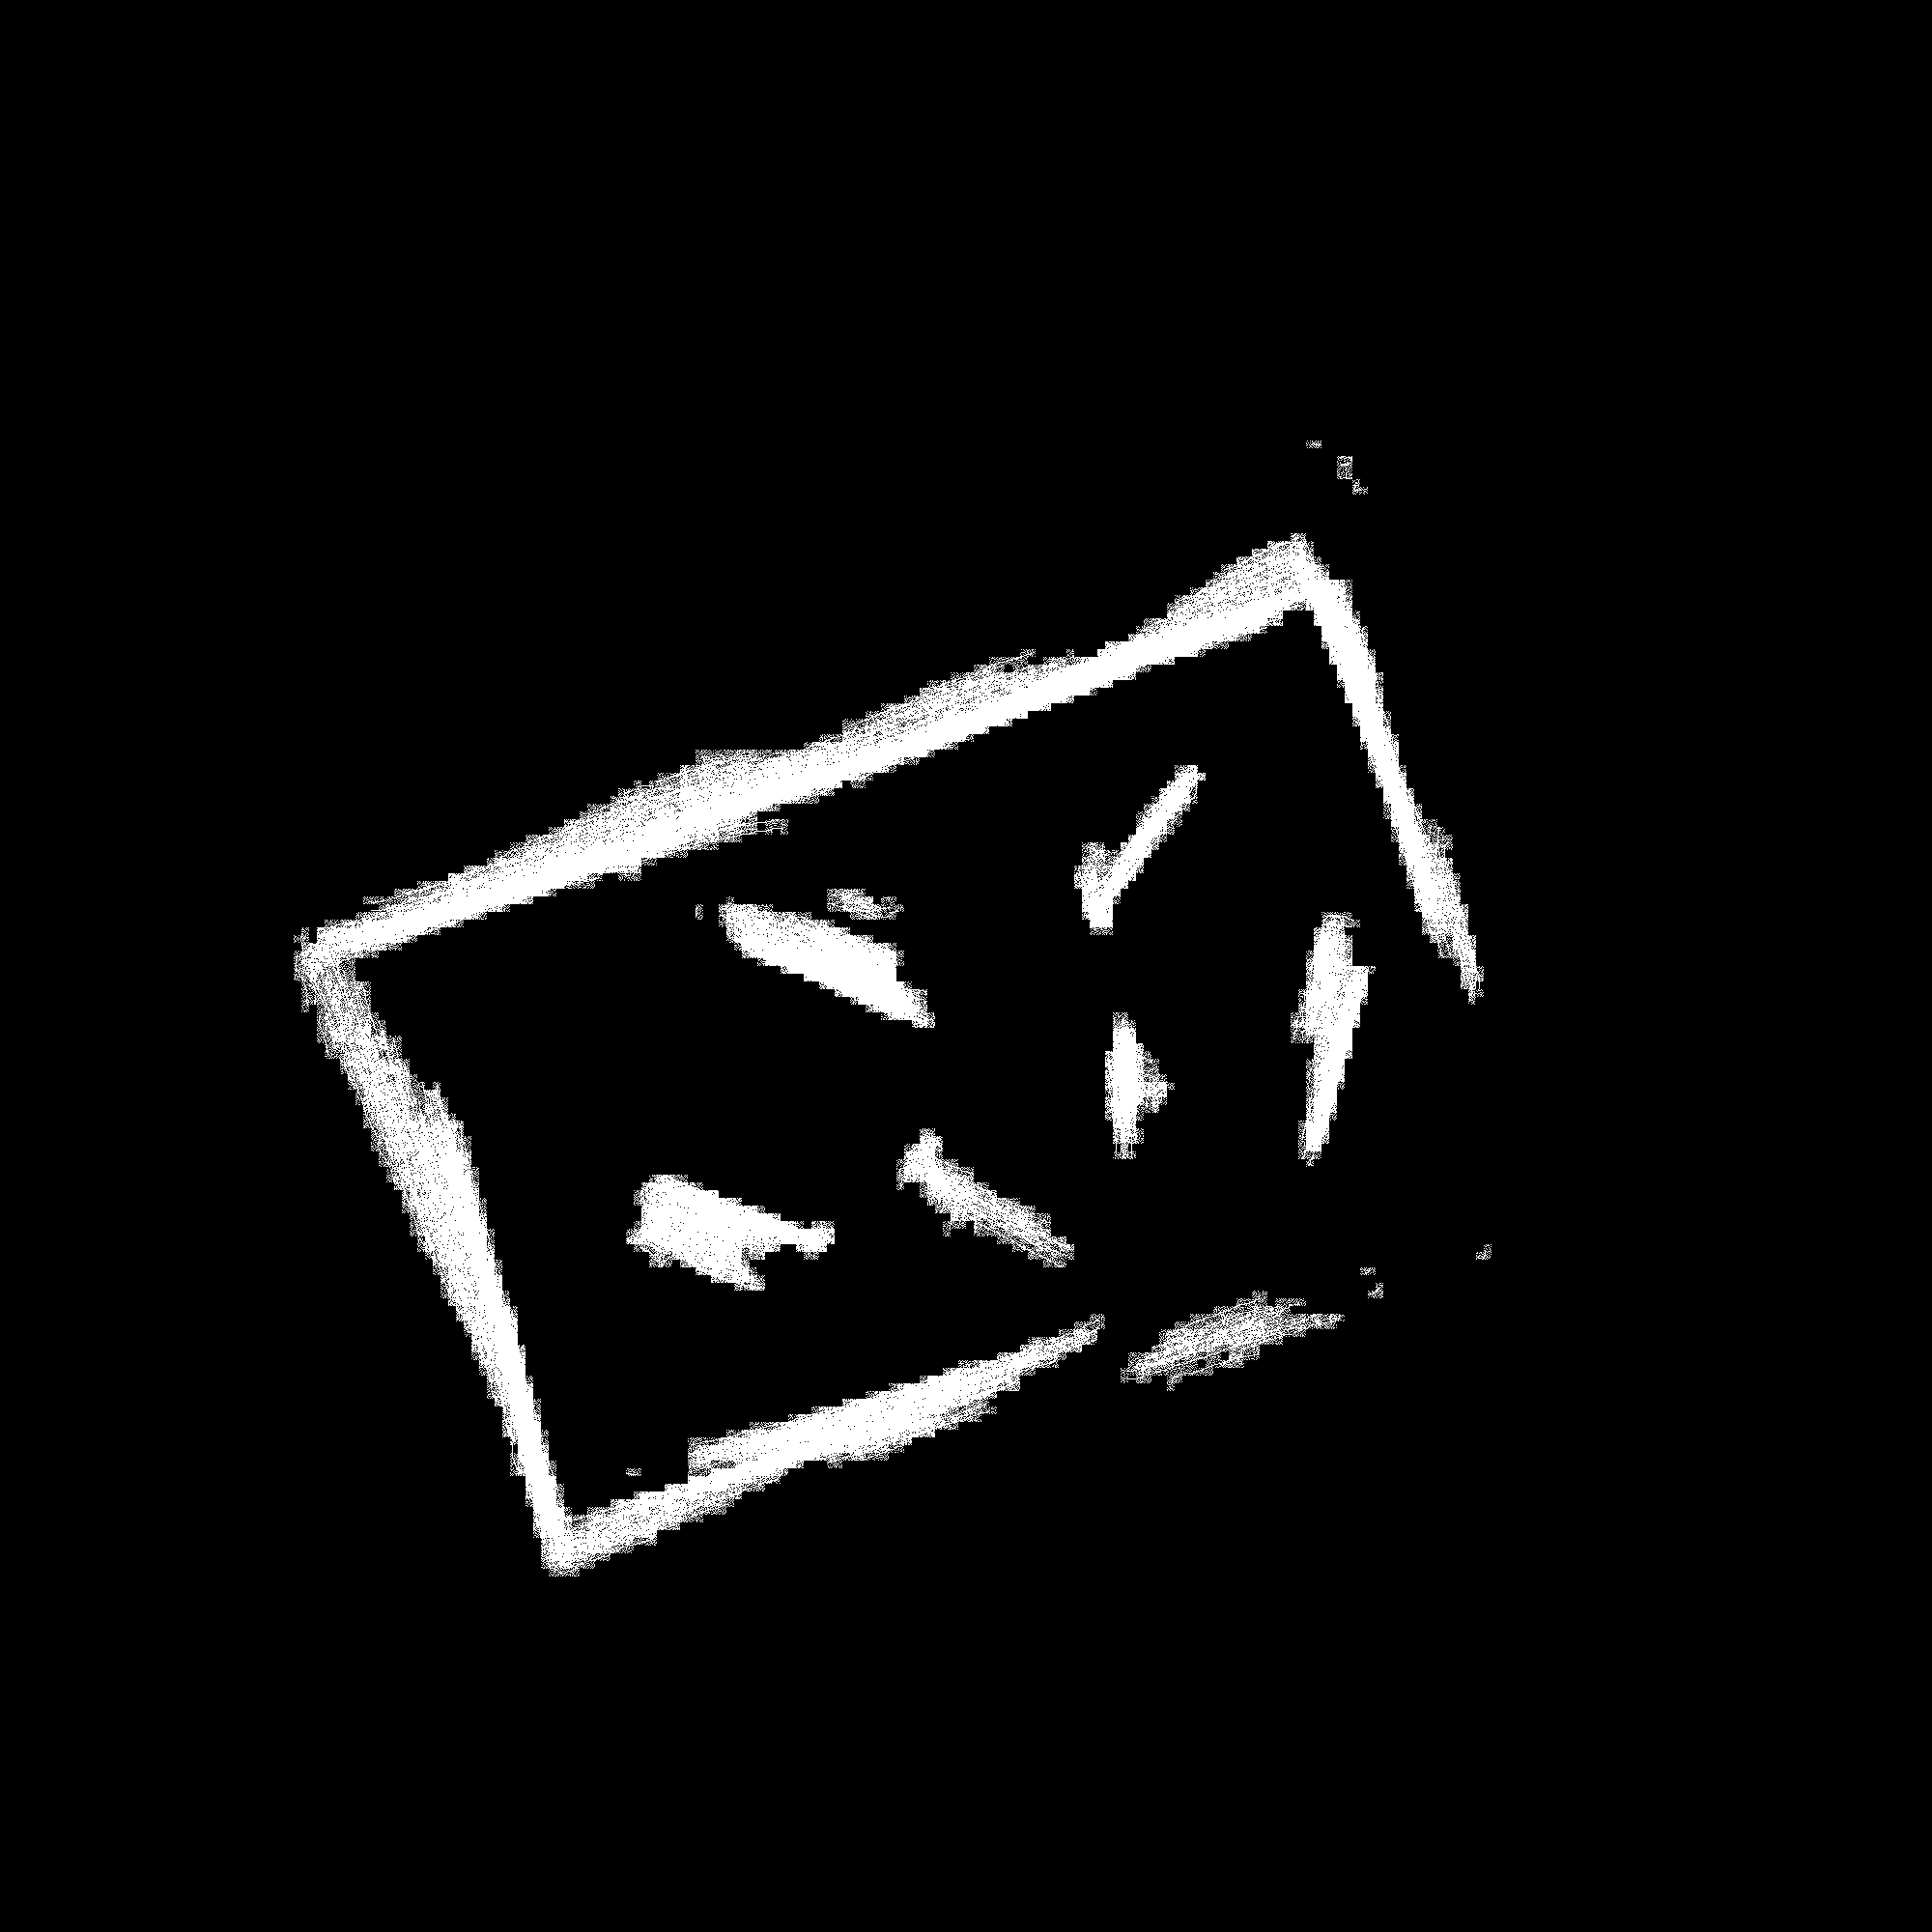

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [116]:
res = None

for i in range(coordinates.shape[0]):
    fig, ax = plt.subplots()
    fig.set_figheight(20)
    fig.set_figwidth(20)
    ax.axis('off')
    ax.set_xlim((0, 10))
    ax.set_ylim((-6, 4))
    ax.set_aspect (1)
    points_session = calculate_session(coordinates[i], lidar[i])
    ax.scatter(points_session[0], points_session[1], 1, 'k')
    
    fig.savefig(f'tmp/tmp_frame.jpg', dpi=100, transparent=True)
    fig.clear()
    ax.clear()

    data = cv2.imread('tmp/tmp_frame.jpg')
    data = cv2.Canny(cv2.blur(data, (9, 9)), 100, 200)
    
    cv2.imwrite('tmp/tmp_frame.jpg', data)
    data = data = cv2.imread('tmp/tmp_frame.jpg', cv2.IMREAD_GRAYSCALE)
    
    if res is None:
        res = np.copy(data)
    
    res = np.logical_or(data, res)


res = res.astype(np.uint8) * 255

Image.fromarray(res)

 - Потом поглядеть на это и еще немного размыть

In [20]:
np.unique(res)

array([255], dtype=uint8)

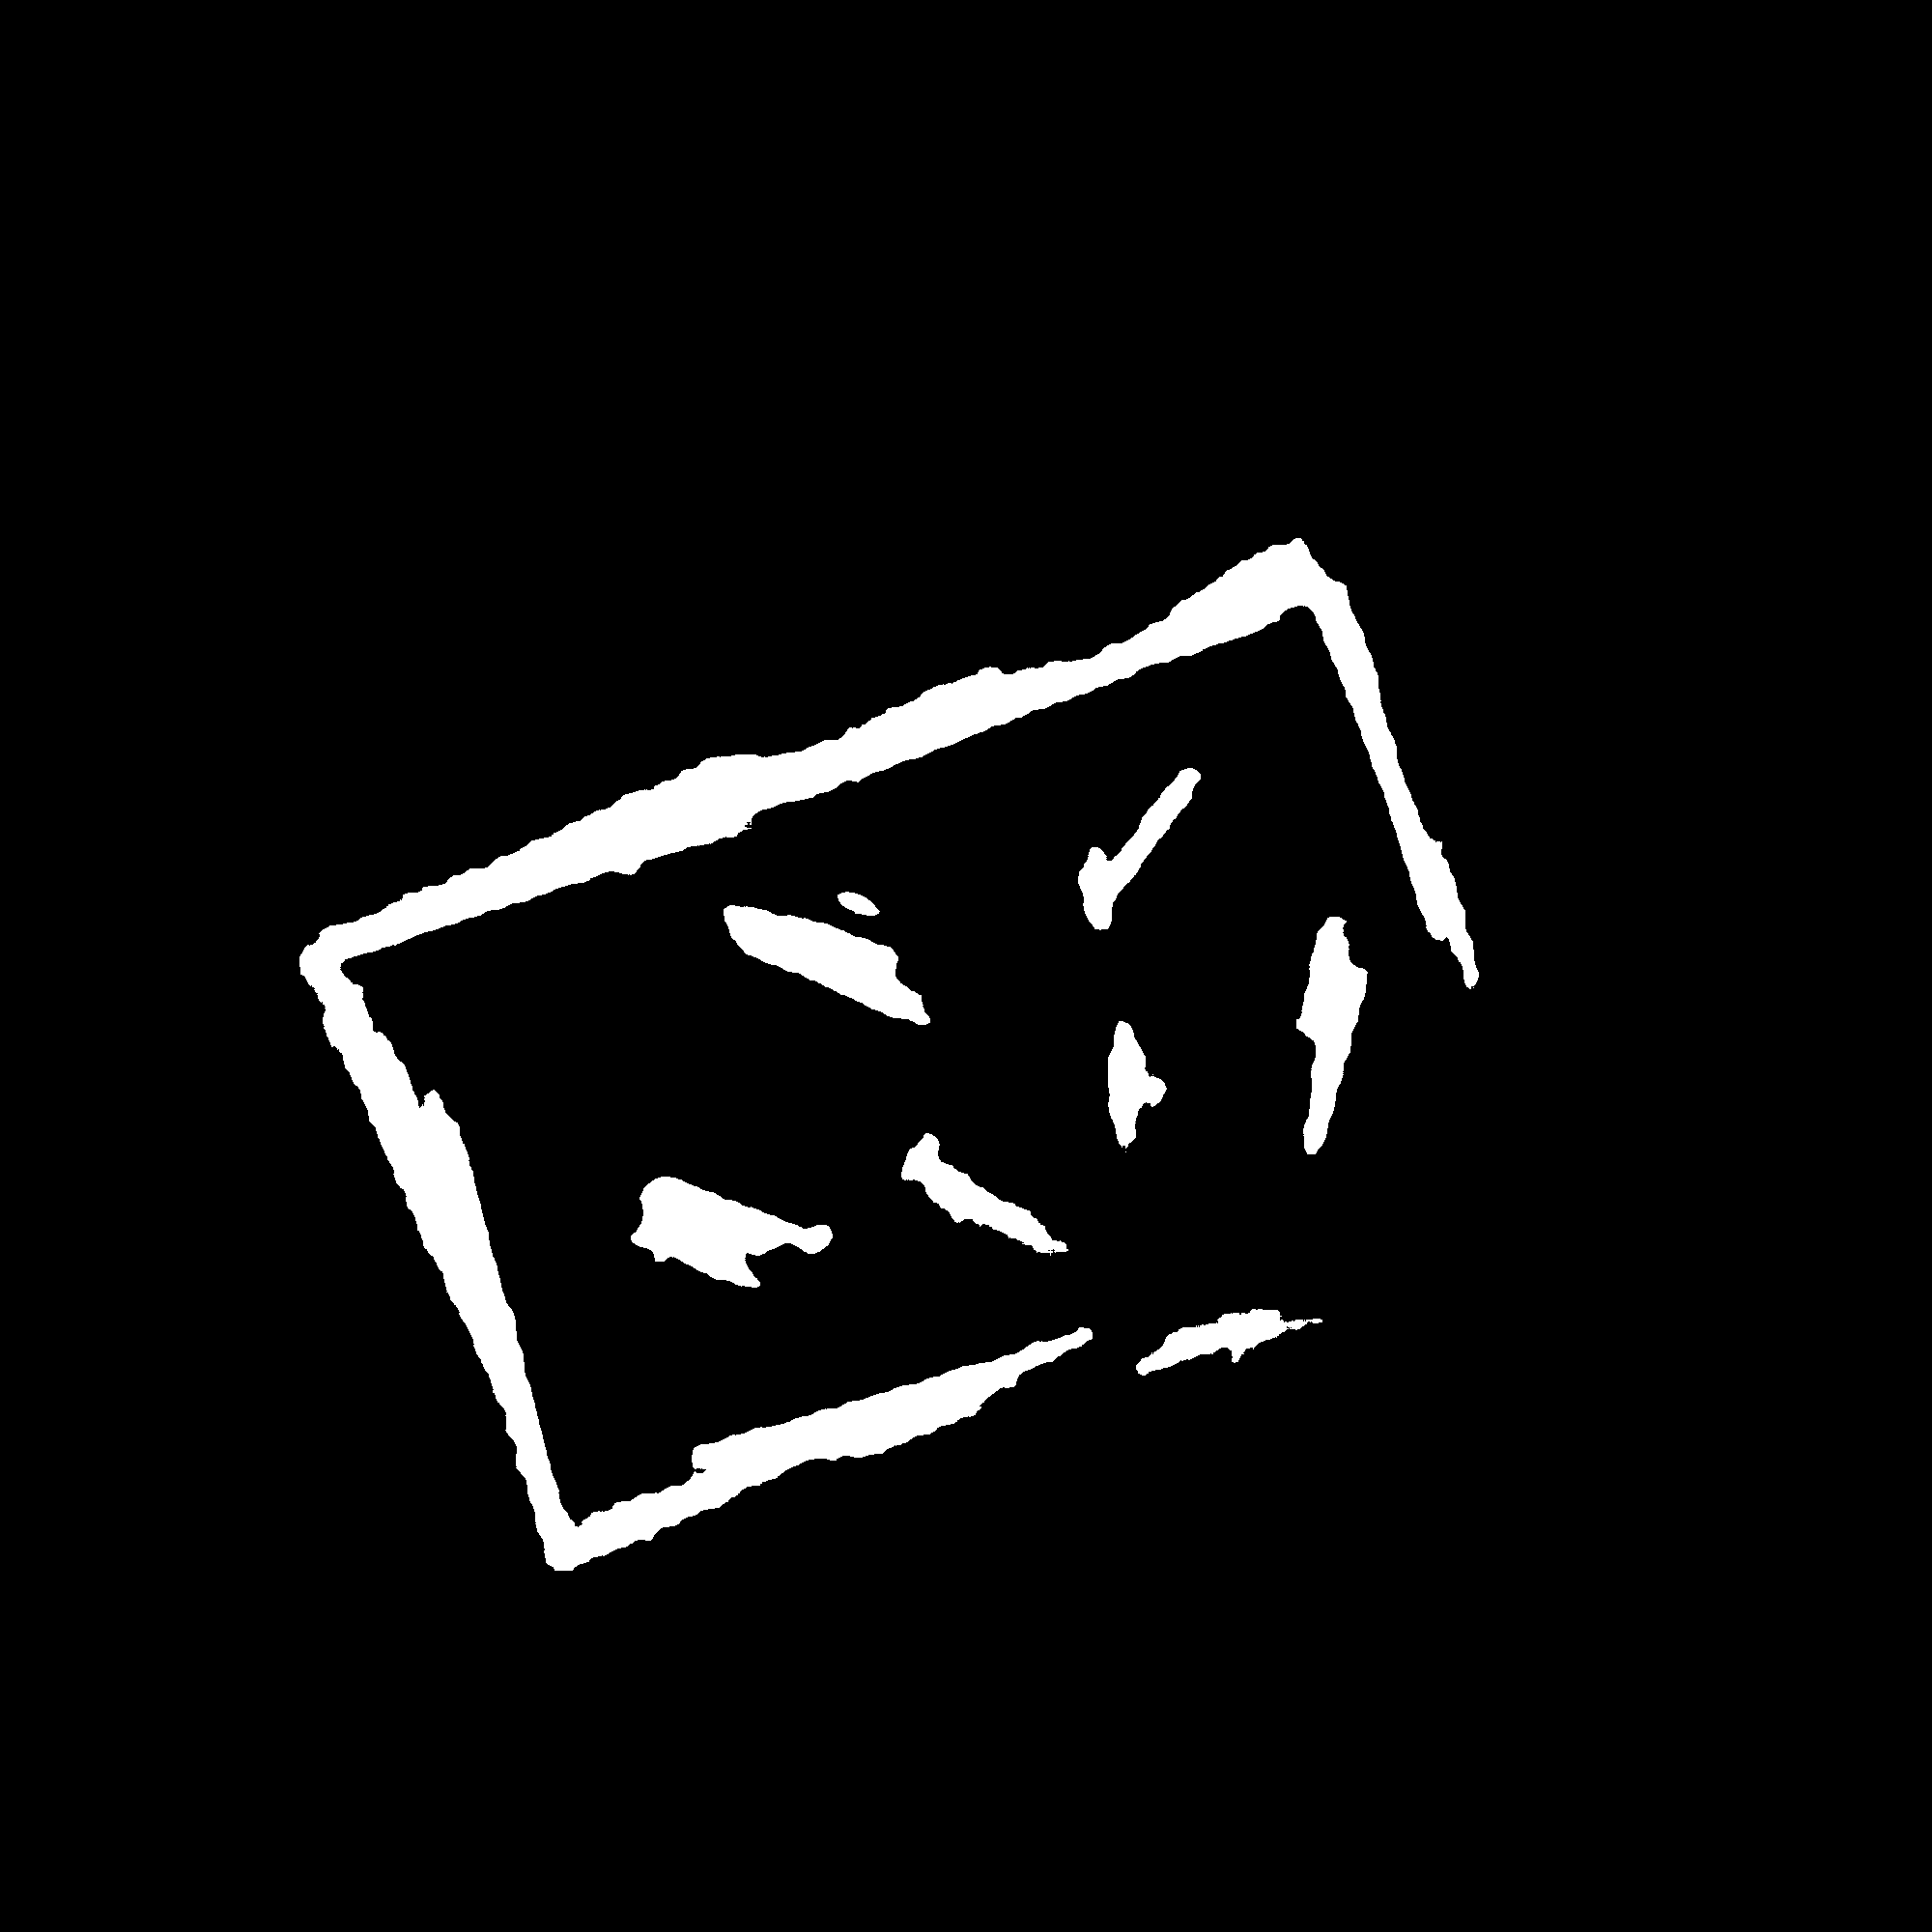

In [118]:
res_test = cv2.blur(res, (13, 13))
thresh = 150
res_test[res_test < thresh] = 0
res_test[res_test >= thresh] = 255
Image.fromarray(res_test)
# cv2.imwrite('result7.jpg', res_test)

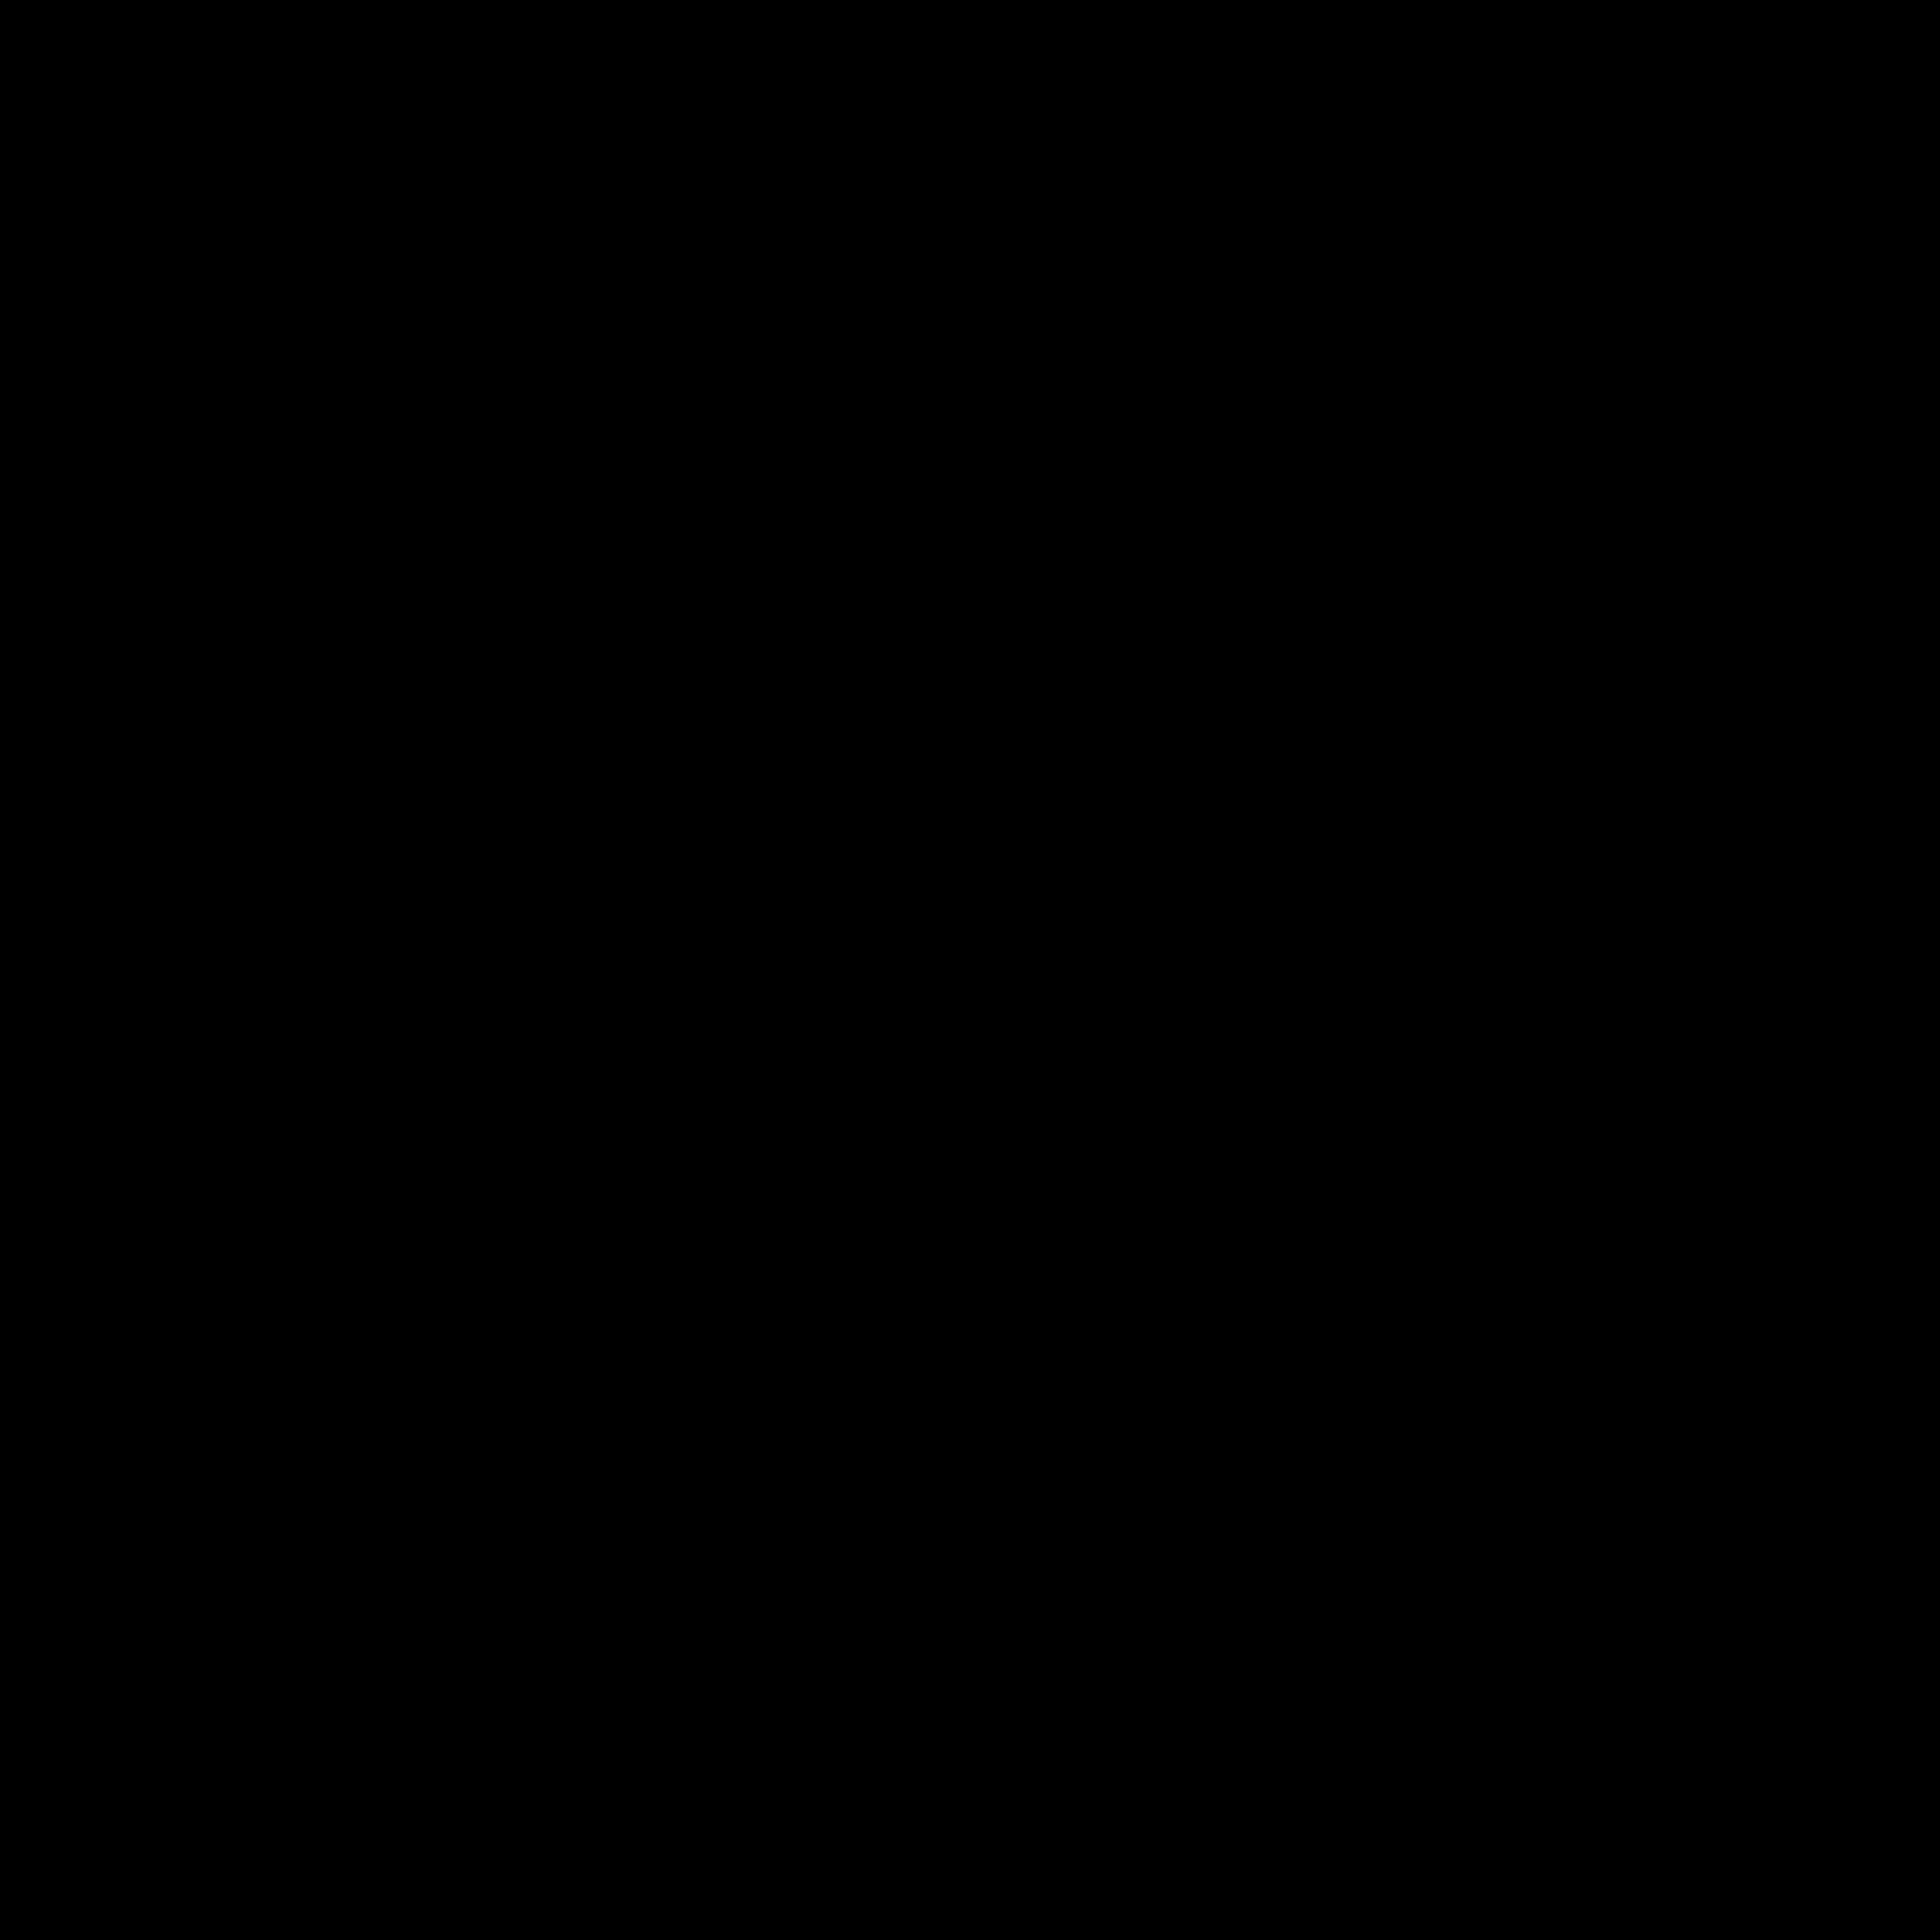

In [28]:
Image.fromarray(cv2.Canny(res_test, 100, 200))

In [33]:
from filterpy.kalman import KalmanFilter

coordinates, lidar = parse_lidar(f'raw_data/examp{7}.txt')

f = KalmanFilter (dim_x=3, dim_z=1)
f.x = coordinates[0]

In [36]:
coordinates[0]

array([ 4.31002 , -3.341503, -2.885309])